In [1]:
import json
import pandas as pd
import numpy as np
import common

c:\Users\cyrus.kfcheung\_Workspace\analyze_word\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8978 (\N{ARC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\cyrus.kfcheung\_Workspace\analyze_word\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9322 (\N{CIRCLED NUMBER ELEVEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\cyrus.kfcheung\_Workspace\analyze_word\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9323 (\N{CIRCLED NUMBER TWELVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\cyrus.kfcheung\_Workspace\analyze_word\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9324 (\N{CIRCLED NUMBER THIRTEEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\cyrus.kfcheung\_Workspace\analyze_word\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

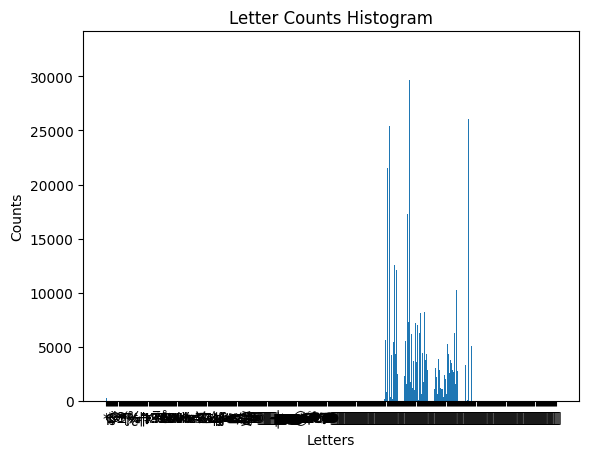

all alphabets: *-¡¢£¦§¨©ª«¬­®°±²³´¶·¸¹º»¼½¾¿÷‐–—―‖‘’“”†‡•‥…′″※‼‾⁇⁈⁉€℃ℓ№℡Åℵ⅓⅔ⅠⅣⅤⅦⅧⅨⅩⅪⅫⅰⅴⅶⅷⅹ←↑→↓↔↖↗↘↙⇄⇒⇔⇦⇧⇨⇩∀∂∃∅∇∈∋−∓√∝∞∟∠∥∧∨∩∪∫∬∮∴∵∽≃≅≈≒≠≡≦≧≪≫⊂⊃⊄⊆⊇⊊⊕⊥⊿⋚⋛⌒⌘①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳⓬⓵⓶─━┐┘├■□▲△▶▷▼▽◀◆◇◉○◎●◐◑◒◓◦◯☀☁☂☃★☆☎☞♀♂♠♡♢♣♥♦♧♨♩♪♫♬♭♯✓❖❶❷❸❹❺❻⤴⦿　、。〃々〆〇〈〉《》「」『』【】〓〔〕〖〗〘〙〜〝〟〳〴〵〻〼〽うすちっなぶほやらる゛゜ゝゞァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロヮワヱヲンヴ・ーヽヾ㈱㈲㉑㉒㉓㉔㉕㊤㊥㊦㊧㌃㌍㌔㌘㌢㌦㌧㌫㌶㌻㍉㍍㍑㍗㎎㎏㎜㎝㎞㎡㏄仝名基変接株病社続詞財﹅！＂＃＄％＆＇（）＊＋，－．／：；＜＝＞？＠ＦＭ［＼］＾＿｀｛｜｝～￣￥
non_alphas: *-¡¢£¦§¨©«¬­®°±²³´¶·¸¹»¼½¾¿÷‐–—―‖‘’“”†‡•‥…′″※‼‾⁇⁈⁉€℃№℡⅓⅔ⅠⅣⅤⅦⅧⅨⅩⅪⅫⅰⅴⅶⅷⅹ←↑→↓↔↖↗↘↙⇄⇒⇔⇦⇧⇨⇩∀∂∃∅∇∈∋−∓√∝∞∟∠∥∧∨∩∪∫∬∮∴∵∽≃≅≈≒≠≡≦≧≪≫⊂⊃⊄⊆⊇⊊⊕⊥⊿⋚⋛⌒⌘①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳⓬⓵⓶─━┐┘├■□▲△▶▷▼▽◀◆◇◉○◎●◐◑◒◓◦◯☀☁☂☃★☆☎☞♀♂♠♡♢♣♥♦♧♨♩♪♫♬♭♯✓❖❶❷❸❹❺❻⤴⦿　、。〃〇〈〉《》「」『』【】〓〔〕〖〗〘〙〜〝〟〽゛゜・㈱㈲㉑㉒㉓㉔㉕㊤㊥㊦㊧㌃㌍㌔㌘㌢㌦㌧㌫㌶㌻㍉㍍㍑㍗㎎㎏㎜㎝㎞㎡㏄﹅！＂＃＄％＆＇（）＊＋，－．／：；＜＝＞？＠［＼］＾＿｀｛｜｝～￣￥
less_than_10: ªºℓÅℵ々〆〳〴〵〻〼うちっなぶほやらゝゞヮヱヽヾ仝名基変接株病社続詞財ＦＭ
outliers: するゥヂヲヴ
remainings: ァアィイウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロワンー


In [2]:
df = pd.read_excel(
    r"word_list\japanese\NLT1.40_freq_list.xlsx",
    sheet_name="NLT 1.40頻度リスト",
)

# extract and rename columns
df = df[["レマ", "読み", "頻度"]].rename(
    columns={"レマ": "annotation", "読み": "word", "頻度": "count"}
)

# cleanse words
df = df[np.isfinite(df["count"])]
df = df.dropna()

common.plot_count_graph(df)
common.analyze_alphabets(df)

In [3]:
# fix format
df["word"] = df["word"].astype(str)
df["count"] = df["count"].astype(int)
agg_functions = {"word": "first", "annotation": "first", "count": "sum"}
df = df.groupby(df["word"], as_index=False).aggregate(agg_functions)

# allowed alphabets
allowed_alphabets = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモャヤュユョヨラリルレロワンー"
df = df[df["word"].str.contains(f"^[{allowed_alphabets}]+$")]

# frequent words
df = df[df["count"] > df["count"].quantile(0.82)]

df["word_len"] = df["word"].apply(len)
df = df.sort_values(by=["word"]).reset_index(drop=True)
df.head()

,word,annotation,count,word_len
0,ア,あ,64415,1
1,アァ,あぁ,5325,2
2,アア,ああ,35999,2
3,アイ,愛,94600,2
4,アイカワラズ,相変わらず,15126,6


In [4]:
df.dtypes

word          object
annotation    object
count          int32
word_len       int64
dtype: object

In [5]:
df.describe()

,count,word_len
count,1.335900e+04,13359.000000
mean,6.703336e+04,4.052773
std,8.868168e+05,1.259365
min,2.489000e+03,1.000000
25%,4.204500e+03,3.000000
50%,8.206000e+03,4.000000
75%,2.311100e+04,5.000000
max,5.726447e+07,10.000000


In [6]:
df[(df["word_len"] >= 3) & (df["word_len"] <= 5) & (df["count"] > 10)].describe()

,count,word_len
count,1.049400e+04,10494.000000
mean,2.989565e+04,3.891366
std,9.957772e+04,0.729376
min,2.489000e+03,3.000000
25%,4.196000e+03,3.000000
50%,8.116000e+03,4.000000
75%,2.190850e+04,4.000000
max,4.111651e+06,5.000000


In [7]:
df.query("'タビタビ' in word")

,word,annotation,count,word_len
7276,タビタビ,たびたび,11536,4


In [8]:
difficulties = {"easy": 0.89, "medium": 0.6, "hard": 0.4, "all": 0}
min_len = 4
max_len = 5

for name, base_percentile in difficulties.items():
    dfs_filtered: list[pd.DataFrame] = []
    lengths: list[str] = []
    for l in range(min_len, max_len + 1):
        df_len = df[df["word_len"] == l]
        # japanese longer words don't need larger vocab pool
        percentile = max(base_percentile - (l - min_len) * 0.15, 0)
        cutoff = df_len["count"].quantile(percentile)
        dfs_filtered.append(
            df_len[df_len["count"] > cutoff]
            .sort_values(by=["count"], ascending=False)
            .reset_index(drop=True)
        )
        lengths.append(f"len{l}: #{len(dfs_filtered[-1])}")
    df_filtered = pd.concat(dfs_filtered)

    print(", ".join(lengths))

    with open(rf"vocabs\ja\ja-{name}.json", "w") as f:
        data = df_filtered["word"].sort_values().tolist()
        json.dump(data, f)
        print(f"{f.name}: {len(df_filtered)} words")

    if name == "all":
        with open(rf"vocabs\ja\ja-annotations.json", "w") as f:
            data = {}
            for index, row in df_filtered.iterrows():
                data[row["word"]] = row["annotation"]
            json.dump(data, f)
            print(f"{f.name}: {len(df_filtered)} annotations")

len4: #527, len5: #594
vocabs\ja\ja-easy.json: 1121 words
len4: #1915, len5: #1256
vocabs\ja\ja-medium.json: 3171 words
len4: #2873, len5: #1712
vocabs\ja\ja-hard.json: 4585 words
len4: #4787, len5: #2281
vocabs\ja\ja-all.json: 7068 words
vocabs\ja\ja-annotations.json: 7068 annotations
